In [1]:
import uproot
import awkward
import numpy as np
from scipy.sparse import csr_matrix

test = uproot.open('../../samples/partGun_PDGid13_x2_E35.0To35.0_NTUP_1.root')['ana']['hgc']

In [2]:
import matplotlib.pyplot as plt

feature_names = ['x','y','layer','t','E']
n_features = len(feature_names)

#thanks Steve :-)
def draw_sample(X, Ri, Ro, cmap='bwr_r', alpha_labels=False,sim_list=None): # y,  # <--- y is edge weights
    # Select the i/o node features for each segment
    feats_o = X[Ro[:,1]]
    feats_i = X[Ri[:,1]]
    y = np.ones(min(feats_o.shape[0],feats_i.shape[0]))
    print 'o',feats_o.shape
    print 'i',feats_i.shape
    # Prepare the figure
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20,12))
    cmap = plt.get_cmap(cmap)
    
    if sim_list is None:    
        # Draw the hits (layer, x, y)
        ax0.scatter(X[:,0], X[:,2], c='k')
        ax1.scatter(X[:,1], X[:,2], c='k')
    else:
        ax0.scatter(X[sim_list,0], X[sim_list,2], c='k')
        ax1.scatter(X[sim_list,1], X[sim_list,2], c='k')
    
    # Draw the segments
    for j in range(y.shape[0]):
        if alpha_labels:
            seg_args = dict(c='k', alpha=float(y[j]))
        else:
            seg_args = dict(c=cmap(float(y[j])))
        ax0.plot([feats_o[j,0], feats_i[j,0]],
                 [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
        ax1.plot([feats_o[j,1], feats_i[j,1]],
                 [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
    # Adjust axes
    ax0.set_xlabel('$x$ [cm]')
    ax1.set_xlabel('$y$ [cm]')
    ax0.set_ylabel('$layer$ [arb]')
    ax1.set_ylabel('$layer$ [arb]')
    plt.tight_layout()

In [17]:
#example of generating a binary ground-truth adjacency matrix 
#for both endcaps in all events for all clusters
#truth is now that hits in adjacent layers are connected 
#and so are hits in the same layer within delta-R < 2 
arrays = test.arrays(['simcluster_hits_indices','rechit_x','rechit_y',
                      'rechit_z','rechit_layer','rechit_time','rechit_energy'])
rechit_x = arrays['rechit_x']
rechit_y = arrays['rechit_y']
rechit_z = arrays['rechit_z']

#flip the x's of negative-endcap hits
#so it's all uniform in x,y,layer coordinates
rechit_x.content[rechit_z.content < 0] *= -1

rechit_time = arrays['rechit_time']
rechit_energy = arrays['rechit_energy']
rechit_layer = arrays['rechit_layer']
sim_indices = awkward.fromiter(arrays['simcluster_hits_indices'])
valid_sim_indices = sim_indices[sim_indices > -1]


def get_features(ievt,mask):
    x = rechit_x[ievt][mask]
    y = rechit_y[ievt][mask]
    layer = rechit_layer[ievt][mask]
    time = rechit_time[ievt][mask]
    energy = rechit_energy[ievt][mask]    
    return np.stack((x,y,layer,time,energy)).T
    
    
mats_out = list()
idx_lists_out = list()
pos_feats = list()
neg_feats = list()
pos_simhits = list()
neg_simhits = list()
for ievt in range(rechit_z.size):
    distincts = valid_sim_indices[ievt].distincts()
        
    pos_z_mask = (rechit_z[ievt] > 0)
    rh_pos_z, = np.where(pos_z_mask)
    rh_neg_z, = np.where(~pos_z_mask)
    rh_idx_map = np.zeros(pos_z_mask.size,dtype=np.int)
    rh_idx_map[pos_z_mask] = np.arange(rh_pos_z.size)
    rh_idx_map[~pos_z_mask] = np.arange(rh_neg_z.size)
        
    pos_feats.append(get_features(ievt,pos_z_mask))
    neg_feats.append(get_features(ievt,~pos_z_mask))
        
    pos_shape = (rh_pos_z.size,rh_pos_z.size)
    neg_shape = (rh_neg_z.size,rh_neg_z.size)
    
    adj_pos_z_fwd = csr_matrix(pos_shape,dtype=np.bool)
    adj_neg_z_fwd = csr_matrix(neg_shape,dtype=np.bool)
    
    adjidx_pos_z_fwd = None
    adjidx_neg_z_fwd = None
    
    adj_pos_z_bkw = csr_matrix(pos_shape,dtype=np.bool)
    adj_neg_z_bkw = csr_matrix(neg_shape,dtype=np.bool)
    
    adjidx_pos_z_bkw = None
    adjidx_neg_z_bkw = None
    
    for iclu in range(distincts.size):
        ispos = np.all(rechit_z[ievt][valid_sim_indices[ievt][iclu]] > 0)
        
        row_fwd = distincts[iclu].i0
        col_fwd = distincts[iclu].i1
        
        row_bkw = distincts[iclu].i1
        col_bkw = distincts[iclu].i0
            
        #layer_row = rechit_layer[ievt][rows]
        #layer_col = rechit_layer[ievt][cols]
        #rhx_row = rechit_x[ievt][rows]
        #rhx_col = rechit_x[ievt][cols]
        #rhy_row = rechit_y[ievt][rows]
        #rhy_col = rechit_y[ievt][cols]
        
        row_layer_fwd = rechit_layer[ievt][row_fwd]
        col_layer_fwd = rechit_layer[ievt][col_fwd]
        row_layer_bkw = rechit_layer[ievt][row_bkw]
        col_layer_bkw = rechit_layer[ievt][col_bkw]
        
        row_x_fwd = rechit_x[ievt][row_fwd]
        col_x_fwd = rechit_x[ievt][col_fwd]
        row_x_bkw = rechit_x[ievt][row_bkw]
        col_x_bkw = rechit_x[ievt][col_bkw]
        
        row_y_fwd = rechit_y[ievt][row_fwd]
        col_y_fwd = rechit_y[ievt][col_fwd]
        row_y_bkw = rechit_y[ievt][row_bkw]
        col_y_bkw = rechit_y[ievt][col_bkw]
        
        #forward is "outgoing" backward is "incoming"
        forward_mask  = np.abs(row_layer_fwd - col_layer_fwd) == 1
        backward_mask = np.abs(row_layer_bkw - col_layer_bkw) == 1
        
        
        #here we define in-layer connections such that ~NNs talk to eachother
        #in-layer connections are bi-directional
        same_layer_fwd = ( (row_layer_fwd == col_layer_fwd) & 
                           (np.hypot(row_x_fwd - col_x_fwd,row_y_fwd-col_y_fwd) < 2.0) )
        same_layer_bkw = ( (row_layer_bkw == col_layer_bkw) & 
                           (np.hypot(row_x_bkw - col_x_bkw,row_y_bkw-col_y_bkw) < 2.0) )
        
        row_fwd = rh_idx_map[row_fwd][forward_mask | same_layer_fwd]
        col_fwd = rh_idx_map[col_fwd][forward_mask | same_layer_fwd]
        data_fwd = np.ones(row_fwd.size,dtype=np.bool)
        
        row_bkw = rh_idx_map[row_bkw][backward_mask | same_layer_bkw]
        col_bkw = rh_idx_map[col_bkw][backward_mask | same_layer_bkw]
        data_bkw = np.ones(row_bkw.size,dtype=np.bool)
        
            
        if ispos:            
            pos_simhits.append(rh_idx_map[valid_sim_indices[ievt][iclu]])
            
            mat_fwd = csr_matrix((data_fwd,(row_fwd,col_fwd)),shape=pos_shape,dtype=np.bool)
            adj_pos_z_fwd += mat_fwd
            mat_bkw = csr_matrix((data_bkw,(row_bkw,col_bkw)),shape=pos_shape,dtype=np.bool)
            adj_pos_z_bkw += mat_bkw
            
            if adjidx_pos_z_bkw is None:
                adjidx_pos_z_fwd = np.stack((row_fwd,col_fwd)).T
                adjidx_pos_z_bkw = np.stack((row_bkw,col_bkw)).T
            else:
                adjidx_pos_z_fwd = np.concatenate((adjidx_pos_z_fwd,np.stack((row_fwd,col_fwd)).T))
                adjidx_pos_z_bkw = np.concatenate((adjidx_pos_z_bkw,np.stack((row_bkw,col_bkw)).T))
            
        else:
            neg_simhits.append(rh_idx_map[valid_sim_indices[ievt][iclu]])
            
            mat_fwd = csr_matrix((data_fwd,(row_fwd,col_fwd)),shape=neg_shape,dtype=np.bool)
            adj_neg_z_fwd += mat_fwd
            mat_bkw = csr_matrix((data_bkw,(row_bkw,col_bkw)),shape=neg_shape,dtype=np.bool)
            adj_neg_z_bkw += mat_bkw    
            
            if adjidx_neg_z_bkw is None:
                adjidx_neg_z_fwd = np.stack((row_fwd,col_fwd)).T
                adjidx_neg_z_bkw = np.stack((row_bkw,col_bkw)).T
            else:
                adjidx_neg_z_fwd = np.concatenate((adjidx_neg_z_fwd,np.stack((row_fwd,col_fwd)).T))
                adjidx_neg_z_bkw = np.concatenate((adjidx_neg_z_bkw,np.stack((row_bkw,col_bkw)).T))
    
    mats_out.append([[adj_pos_z_fwd,adj_pos_z_bkw],[adj_neg_z_fwd,adj_neg_z_bkw]])
    idx_lists_out.append([[adjidx_pos_z_fwd,adjidx_pos_z_bkw],[adjidx_neg_z_fwd,adjidx_neg_z_bkw]])


o (153, 5)
i (153, 5)


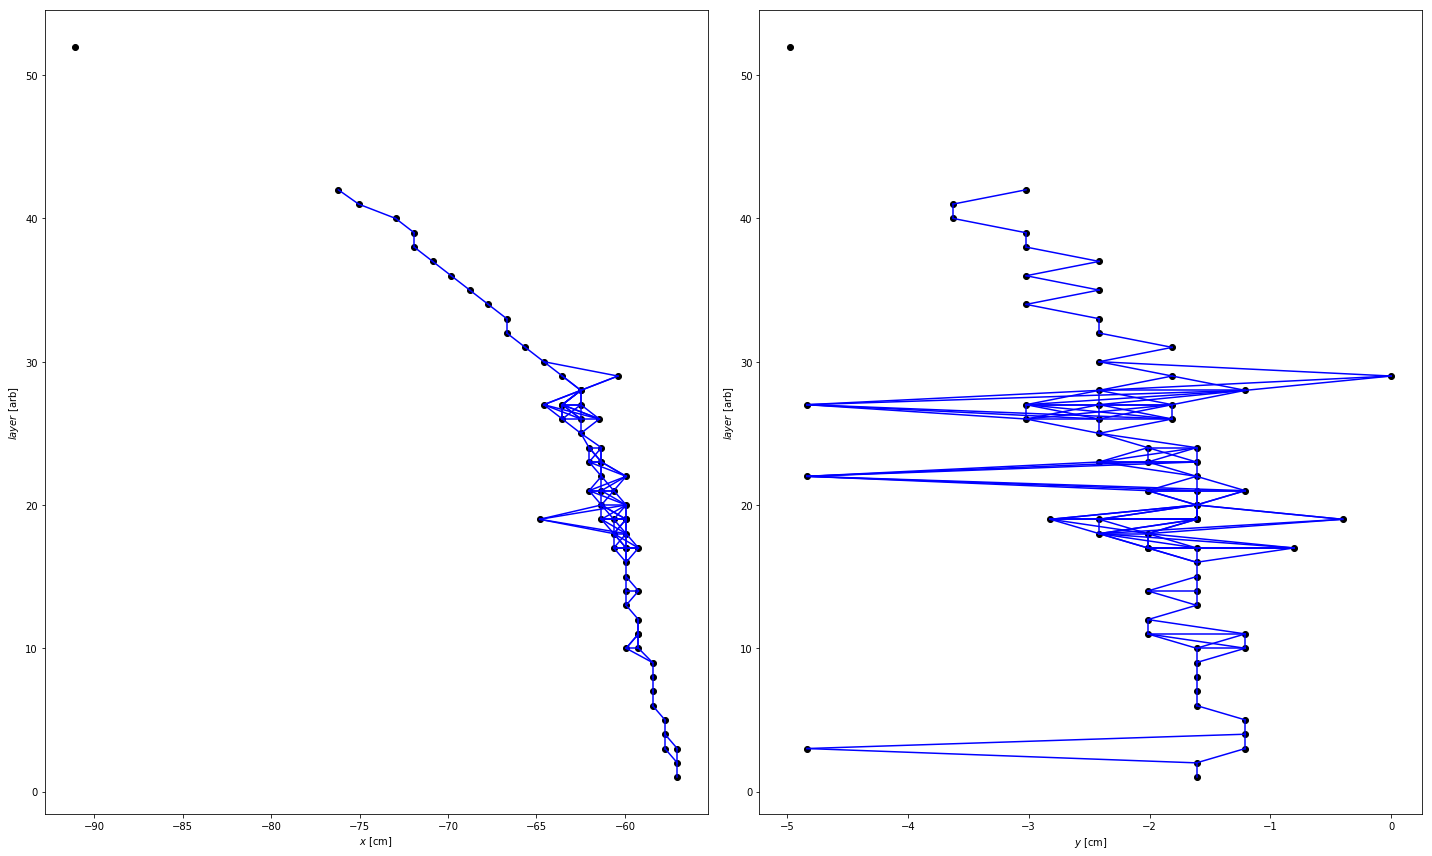

In [21]:
draw_sample(pos_feats[0],idx_lists_out[0][0][1],idx_lists_out[0][0][0],sim_list=pos_simhits[0])